In [1]:
import sys
sys.path.append('../')

import jax
from jax import numpy as jp
import matplotlib.pyplot as plt
from IPython.display import HTML
from brax.io import model, html
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from src import networks
from utils import get_env_config, create_env
import pickle
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
RUN_FOLDER_PATH = '/home/kw2960/JaxGCRL/runs/run_ant-crl-clean_s_1'
CKPT_NAME = '/step_11427840.pkl'

In [3]:
params = model.load_params(RUN_FOLDER_PATH + '/ckpt' + CKPT_NAME)
processor_params, policy_params, encoders_params = params
sa_encoder_params, g_encoder_params = encoders_params['sa_encoder'], encoders_params['g_encoder']

In [4]:
args_path = RUN_FOLDER_PATH + '/args.pkl'

with open(args_path, "rb") as f:
    args = pickle.load(f)

config = get_env_config(args)

In [5]:
env = create_env(args)
obs_size = env.observation_size
action_size = env.action_size
print(obs_size, action_size)

31 8


In [6]:
crl_networks = networks.make_crl_networks(config, env, obs_size, action_size)

inference_fn = networks.make_inference_fn(crl_networks)
inference_fn = inference_fn(params[:2])

sa_encoder = lambda obs: crl_networks.sa_encoder.apply(processor_params, sa_encoder_params, obs)
g_encoder = lambda obs: crl_networks.g_encoder.apply(processor_params, g_encoder_params, obs)

In [7]:
jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

In [8]:
NUM_EPISODES = 1

trajectories = []
rollouts = []
rewards = []

for episode in range(NUM_EPISODES):
    trajectory = []
    reward = []
    rng = jax.random.PRNGKey(seed=episode)
    state = jit_env_reset(rng=rng)
    # print(state.reward)
    for _ in range(1000):
        rollouts.append(state.pipeline_state)
        act_rng, rng = jax.random.split(rng)
        # print(state.obs.shape)
        act, _ = jit_inference_fn(state.obs, act_rng)
        trajectory.append((state,act))
        reward.append(state.reward.item())
        state = jit_env_step(state, act)
    rewards.append(reward)
    trajectories.append(trajectory)

In [9]:
# print(rewards[0])

In [10]:
# html.save("ant-crl-clean.html", env.sys.tree_replace({'opt.timestep': env.dt}), rollouts) 

# HTML(html.render(env.sys.tree_replace({'opt.timestep': env.dt}), rollouts))

In [11]:
TRAJECTORY_TO_DRAW = 0

raw_observations = np.array([state.obs for (state, _) in trajectories[TRAJECTORY_TO_DRAW]])
actions = np.array([act for (_, act) in trajectories[TRAJECTORY_TO_DRAW]])

observations = raw_observations[:, :obs_size]

encoded_sa = sa_encoder(jp.concatenate((observations[:, :-2], actions), axis = 1))
encoded_g = g_encoder(observations[:, -2:])
print("encoded sa", encoded_sa.shape)
print(encoded_g.shape)
# encoded_sag = jp.concatenate((encoded_sa, encoded_g[:1,:]), axis = 0)
# print("encoded-sag", encoded_sag.shape)

encoded sa (1000, 64)
(1000, 64)


In [12]:
scaled_encodings = StandardScaler().fit_transform(encoded_sa)
features = PCA(n_components=2).fit_transform(scaled_encodings)

total reward 118.0


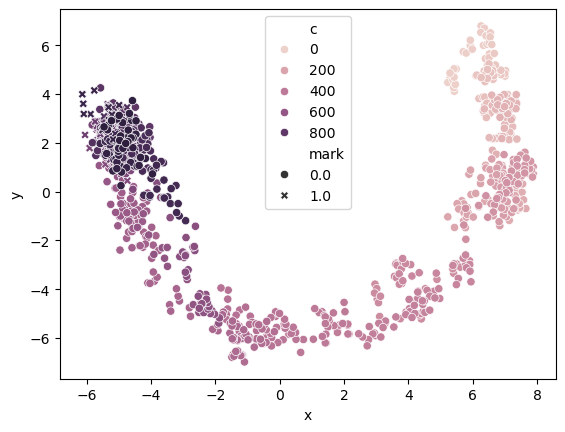

In [13]:
# Make Figure
x = features[:,0]
y = features[:,1]
c = np.arange(0, 1000)
mark = rewards[TRAJECTORY_TO_DRAW]
# print(mark)
df = pd.DataFrame({'x':x,'y':y,'c':c, 'mark':mark})
scatter_plot = sns.scatterplot(data = df, x='x', y='y', hue='c', style='mark')

scatter_fig = scatter_plot.get_figure()
scatter_fig.savefig('scatterplot.png')

# fig = swarm_plot.get_figure()
# fig.savefig("out.png") 

# plt.scatter(features[:1000,0], features[:1000,1], c=np.arange(0, 1000))
# # plt.scatter(features[1000:,0], features[1000:,1], c='0')
# plt.colorbar(label="timestep")
# plt.title(f"Trajectory{TRAJECTORY_TO_DRAW} (s,a) embeddings, {args.env_name}, {CKPT_NAME}")
# plt.savefig("pca.png")

print("total reward", np.sum(rewards[TRAJECTORY_TO_DRAW]))

In [14]:
true_goal = observations[-1, -2:] # could be any observations[INT (0-1000), -2:]
last_state = observations[-1, :2] # imagined goal based on last state of the trajectory
print(true_goal)
print(last_state)
# dist = jnp.linalg.norm(obs[:2] - obs[-2:])
# success = jnp.array(dist < self.goal_dist, dtype=float)

[-9.263674  -3.7662115]
[-8.768478  -3.2339742]


In [15]:
jit_env_reset_with_target = jax.jit(env.reset_with_target)

In [16]:
NUM_EPISODES = 1

infer_trajectories = []
infer_rollouts = []
infer_rewards = []
infer_true_successes = [] # based on true goal 

for episode in range(NUM_EPISODES):
    infer_trajectory = []
    infer_reward = []
    infer_true_success = []
    rng = jax.random.PRNGKey(seed=episode)
    state = jit_env_reset_with_target(rng=rng, target=last_state)
    print(state.obs)
    for _ in range(1000):
        infer_rollouts.append(state.pipeline_state)
        act_rng, rng = jax.random.split(rng)
        # print(state.obs.shape)
        act, _ = jit_inference_fn(state.obs, act_rng)
        # print(state.obs[-2:])
        infer_trajectory.append((state,act))
        # print(infer_trajectory[0][0].obs[-2:])
        
        # get success/reward based on true goal
        # print(state.obs[:2].shape, true_goal.shape)
        dist = jp.linalg.norm(state.obs[:2] - true_goal)
        # print(dist.shape)
        success = jp.array(dist < env.goal_dist, dtype=float)
        infer_true_success.append(success.item())

        infer_reward.append(state.reward.item())
        state = jit_env_step(state, act)
    infer_rewards.append(infer_reward)
    infer_trajectories.append(infer_trajectory)
    infer_true_successes.append(infer_true_success)
    
print(infer_trajectories[0][0][0].obs[-2:])

[ 3.00218910e-03 -4.32271734e-02  5.08071601e-01  9.34209585e-01
  9.99258235e-02 -1.29214525e-02 -5.92630170e-02  8.33190456e-02
  1.01426196e+00 -9.48459655e-02 -1.03614187e+00  2.44859233e-02
 -1.09609950e+00 -5.72115667e-02  9.78265464e-01  2.13161767e-01
  2.26637632e-01 -1.79885291e-02 -1.35182172e-01  2.42620725e-02
 -1.24832086e-01 -7.41649941e-02 -1.10123105e-01 -1.52591011e-02
  1.39247388e-01 -1.52174681e-01 -3.90023850e-02  5.40192239e-03
  1.56412572e-01 -8.76847839e+00 -3.23397422e+00]
[-8.768478  -3.2339742]


In [17]:
TRAJECTORY_TO_DRAW = 0

infer_raw_observations = np.array([state.obs for (state, _) in infer_trajectories[TRAJECTORY_TO_DRAW]])
infer_actions = np.array([act for (_, act) in infer_trajectories[TRAJECTORY_TO_DRAW]])

infer_observations = infer_raw_observations[:, :obs_size]
print("inferred goal", infer_observations[:, -2:])

encoded_sa = sa_encoder(jp.concatenate((infer_observations[:, :-2], infer_actions), axis = 1))
encoded_g = g_encoder(infer_observations[:, -2:])
print("encoded sa", encoded_sa.shape)
print(encoded_g.shape)
# encoded_sag = jp.concatenate((encoded_sa, encoded_g[:1,:]), axis = 0)
# print("encoded-sag", encoded_sag.shape)

inferred goal [[-8.768478  -3.2339742]
 [-8.768478  -3.2339742]
 [-8.768478  -3.2339742]
 ...
 [-8.768478  -3.2339742]
 [-8.768478  -3.2339742]
 [-8.768478  -3.2339742]]
encoded sa (1000, 64)
(1000, 64)


In [18]:
scaled_encodings = StandardScaler().fit_transform(encoded_sa)
features = PCA(n_components=2).fit_transform(scaled_encodings)

total reward with inferred goal 140.0


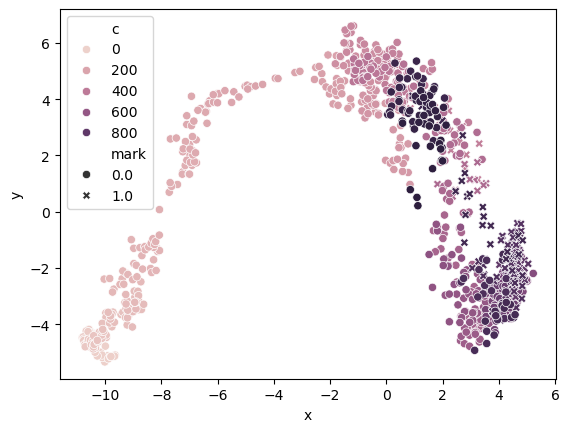

In [19]:
# Make Figure
x = features[:,0]
y = features[:,1]
c = np.arange(0, 1000)
mark = infer_rewards[TRAJECTORY_TO_DRAW]
# print(mark)
df = pd.DataFrame({'x':x,'y':y,'c':c, 'mark':mark})
scatter_plot = sns.scatterplot(data = df, x='x', y='y', hue='c', style='mark')

scatter_fig = scatter_plot.get_figure()
scatter_fig.savefig('scatterplot_inferred_goal.png')

# fig = swarm_plot.get_figure()
# fig.savefig("out.png") 

# plt.scatter(features[:1000,0], features[:1000,1], c=np.arange(0, 1000))
# # plt.scatter(features[1000:,0], features[1000:,1], c='0')
# plt.colorbar(label="timestep")
# plt.title(f"Trajectory{TRAJECTORY_TO_DRAW} (s,a) embeddings, {args.env_name}, {CKPT_NAME}")
# plt.savefig("pca.png")

print("total reward with inferred goal", np.sum(infer_rewards[TRAJECTORY_TO_DRAW]))

total reward with true goal 95.0


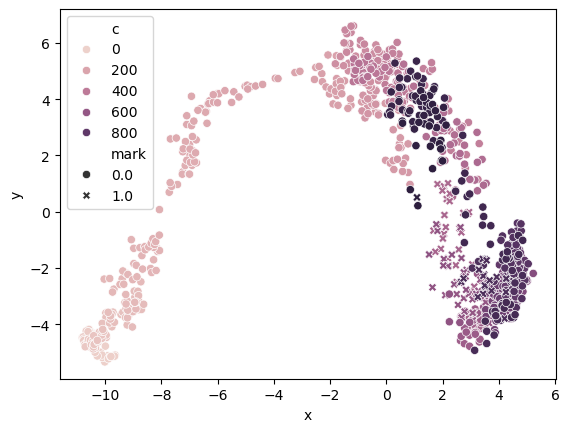

In [20]:
# Make Figure
x = features[:,0]
y = features[:,1]
c = np.arange(0, 1000)
mark = infer_true_successes[TRAJECTORY_TO_DRAW]
# print(mark)
df = pd.DataFrame({'x':x,'y':y,'c':c, 'mark':mark})
scatter_plot = sns.scatterplot(data = df, x='x', y='y', hue='c', style='mark')

scatter_fig = scatter_plot.get_figure()
scatter_fig.savefig('scatterplot_inferred_goal.png')

# fig = swarm_plot.get_figure()
# fig.savefig("out.png") 

# plt.scatter(features[:1000,0], features[:1000,1], c=np.arange(0, 1000))
# # plt.scatter(features[1000:,0], features[1000:,1], c='0')
# plt.colorbar(label="timestep")
# plt.title(f"Trajectory{TRAJECTORY_TO_DRAW} (s,a) embeddings, {args.env_name}, {CKPT_NAME}")
# plt.savefig("pca.png")

print("total reward with true goal", np.sum(infer_true_successes[TRAJECTORY_TO_DRAW]))